# Projet radiologie bootcamp DST : analyse de données exploratoire

## Plan d'analyse
* Data collection : Liste des fichiers
* Classes : nombre et description
* Population
* Quelles infos peuvent être utilisées ? 
* Questions & remarques sur les données
* data cleaning ?
* Analyse sur chaque variable : distribution
* Valeurs manquantes ou abbérantes ?

Problématique métier :
* Enjeux de la détection COVID par X-ray ? vs à l'oeil nu ? 
* Puisque COVID-19 attaque les cellules épithéliales qui tapissent nos voies respiratoires, nous pouvons utiliser des rayons X pour analyser la santé des poumons d'un patient. (SOURCE ?)
* Le développement d'un système de diagnostic automatisé est peut être utile pour faire gagner du temps aux professionnels de santé.
Les radiographies pulmonaires sont pour leur part rapides à réaliser, et courantes dans les hôpitaux. Le goulot d'étranglement entre la prise d'une radiographie et son interprétation consiste généralement à trouver un radiologue pour la lire et l'interpréter. Le fait qu'une IA le fasse à sa place pourrait signifier que les résultats seront disponibles beaucoup plus rapidement. (source : https://www.zdnet.fr/actualites/de-l-ia-open-source-pour-identifier-les-infections-au-coronavirus-39902053.htm)

Projets existants : 
* COVID-NET développé par DarwinAI Corp., Canada and Vision and Image Processing Research Group, University of Waterloo, Canada  https://arxiv.org/abs/2003.09871 / https://alexswong.github.io/COVID-Net/
* Algo développé par Siemens sur la base d'images de scanner (pas radio!) : https://www.siemens-healthineers.com/fr/medical-imaging/ai-covid-19-algorithm



Limites identifiées :
* https://france-science.com/covid-19-utilisation-des-donnees-et-de-lintelligence-artificielle-aux-etats-unis-pour-lutter-contre-la-maladie/?print=print
* https://www.ictjournal.ch/articles/2021-05-21/les-lacunes-des-algorithmes-pour-diagnostiquer-la-covid-19-dans-les
* https://www.cmaj.ca/content/cmaj/193/44/E1716.full.pdf
* Basé sur 1 image seulement, vs plusieurs examens & historique
* repose sur la bonne labélisation des données dans le dataset => fiabilité des tests et des images annotées par les professionnels qui ont consolidé le dataset  

Le dataset contient des images des radiographies (CXR : Chest X-Ray) de la poitrine de patients positifs COVID-19, sains ou porteurs d'une pneumonie virale.
Toutes les images sont fournies avec les masques (fichiers images distincts) permettant de séparer la zone correspondant aux poumons.

Type de fichiers 
* images : Portable Network Graphics (PNG) file format
* fichiers métadata : excel

In [6]:
from os import listdir
print("Racine : " + str(listdir("../data")))
print("Sous_dossiers : ")
#for dossier in listdir("../data"):
#    print(dossier + ":" + str(listdir("../data/" + dossier)))

Racine : ['COVID', 'COVID.metadata.xlsx', 'Lung_Opacity', 'Lung_Opacity.metadata.xlsx', 'Normal', 'Normal.metadata.xlsx', 'README.md.txt', 'test', 'Viral Pneumonia', 'Viral Pneumonia.metadata.xlsx']
Sous_dossiers : 


## OPENCV commands pour l'analyse d'image
Pour openCV (je vous fais la synthèse car vous n'allez pas vous taper tout mon code - pas très bien structuré et commenté, j'ai fait au plus vite ):

* Lecture d'une image sans rien changer au format : **img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)**
* Lecture d'une image en la convertissant directement en grayscale : **img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)**
* Redimensionnement d'une image : **img_resized = cv2.resize(img, (256,256))**
* plusieurs arguments de type de resize possibles, j'ai laissé celui par défaut
* Application d'un masque (c'est un ET bit à bit) : **img_mask = cv2.bitwise_and(img_resized, mask)**
* Calcul valeur moyenne et écart-type d'une image : **mean, std_dev = cv2.meanStdDev(img_resized, mask)**
* je vous mets l'exemple ou on donne le mask directement à la fonction
* sinon on lui donne l'image avec mask déjà appliqué (et donc pas d'argument mask)
* Calcul histogramme : **hist = cv2.calcHist([img_resized], [0], mask, [256], [0,256])**
* pareil, je vous mets l'exemple ou on donne le mask directement à la fonction
* sinon on lui donne l'image avec mask déjà appliqué (et donc pas d'argument mask)

## Packages

In [3]:
#Import des bibliothèques
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
from PIL import Image, ImageOps
import os, pathlib
from tqdm import tqdm

## Création du dataset : 

### A) Import et fusion des fichiers métadata

In [7]:
meta_Covid = pd.read_excel("../data/COVID.metadata.xlsx")
print(meta_Covid.info())
meta_Covid.insert(loc = 0, column="SET", value =  "COVID")
meta_Covid.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3616 entries, 0 to 3615
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   FILE NAME  3616 non-null   object
 1   FORMAT     3616 non-null   object
 2   SIZE       3616 non-null   object
 3   URL        3616 non-null   object
dtypes: object(4)
memory usage: 113.1+ KB
None


,SET,FILE NAME,FORMAT,SIZE,URL
0,COVID,COVID-1,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
1,COVID,COVID-2,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
2,COVID,COVID-3,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
3,COVID,COVID-4,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
4,COVID,COVID-5,PNG,256*256,https://sirm.org/category/senza-categoria/covi...


In [8]:
meta_Normal = pd.read_excel("../data/Normal.metadata.xlsx")
print(meta_Normal.info())
meta_Normal.head()
meta_Normal.insert(loc = 0, column="SET", value =  "NORMAL")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10192 entries, 0 to 10191
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   FILE NAME  10192 non-null  object
 1   FORMAT     10192 non-null  object
 2   SIZE       10192 non-null  object
 3   URL        10192 non-null  object
dtypes: object(4)
memory usage: 318.6+ KB
None


In [9]:
meta_VPneu = pd.read_excel("../data/Viral Pneumonia.metadata.xlsx")
print(meta_VPneu.info())
meta_VPneu.head()
meta_VPneu.insert(loc = 0, column="SET", value =  "VIRAL_PNEUMONIA")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1345 entries, 0 to 1344
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   FILE NAME  1345 non-null   object
 1   FORMAT     1345 non-null   object
 2   SIZE       1345 non-null   object
 3   URL        1345 non-null   object
dtypes: object(4)
memory usage: 42.2+ KB
None


In [10]:
meta_LO = pd.read_excel("../data/Lung_Opacity.metadata.xlsx")
print(meta_LO.info())
meta_LO.head()
meta_LO.insert(loc = 0, column="SET", value =  "LUNG_OPACITY")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6012 entries, 0 to 6011
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   FILE NAME  6012 non-null   object
 1   FORMAT     6012 non-null   object
 2   SIZE       6012 non-null   object
 3   URL        6012 non-null   object
dtypes: object(4)
memory usage: 188.0+ KB
None


In [11]:
#Fusion des 4 metafichiers dans un dataframe
metadata = pd.concat([meta_Covid, meta_LO, meta_Normal, meta_VPneu], axis = 0)
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21165 entries, 0 to 1344
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   SET        21165 non-null  object
 1   FILE NAME  21165 non-null  object
 2   FORMAT     21165 non-null  object
 3   SIZE       21165 non-null  object
 4   URL        21165 non-null  object
dtypes: object(5)
memory usage: 992.1+ KB


In [13]:
#Lecture et ajout de la luminosité moyenne et des niveaux de gris (mean_luminance)

### Import et extraction d'un sous-set des images X-ray comme arrays, avec leurs dimensions


In [4]:
#Cette fonction permet d'ouvrir une image en Grayscale et de renvoyer ses dimensions ainsi que sa matrice aplatie 

#Fonction qui retourne les dimensions
def get_img(file):
    #ouvrir l'image
    im = Image.open(file).convert("L")
    #transformer en array 
    im_arr = np.array(im)
    h, w = im_arr.shape
    #aplatir la matrice en vecteur 1D
    im_arr = np.ravel(im_arr)
    #renvoie un array avec le chemin d'accès en string, les dimensions, et l'array de pixels
    return np.concatenate(([str(file),h,w],im_arr)).transpose()



['..\\data\\COVID\\images\\COVID-1.png' '299' '299' ... '1' '45' '167']
(89404,)
['185' '40' '0' ... '1' '45' '167']
<class 'numpy.ndarray'>


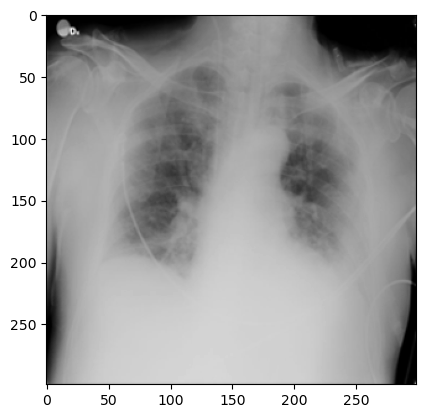

In [5]:
#Test de la fonction
fichier = "..\\data\\COVID\\images\\COVID-1.png"
img = get_img(fichier)
print(img)
print(img.shape)

print(img[3:])
#C'est un array
img = np.array(img[3:].reshape((299,299))).astype("float")
print(type(img))
#img = Image.fromarray(img, )
plt.imshow(img, cmap='gray')
plt.show()


In [12]:
#Cette fonction  permet d'itérer sur les images présentes dans un dossier et d'enregistrer le filepath, dimensions, arrays dans un dataframe
#Elle prend en input un dict avec les noms des dossiers et leurs chemins : 

#Noms de colonnes pour le futur dataframes
#rownm = ["row" + str(i) for i in range(1,299)]
#colnm = ["col" + str(i) for i in range(1,299)]
#cols = ["filepath", "Height", "Width"] + rownm + colnm

def img_to_df(dossier, nb_samples):
    #itérer sur les images d'un dossier
    for n,filepath in tqdm(dossier.items()):
        for f in np.random.choice(os.listdir(filepath), nb_samples, replace = False):
            img_dimsarray = get_img(pathlib.Path(filepath + f))
            try :
                img_mat = np.vstack((img_mat,img_dimsarray))
            except UnboundLocalError:
                img_mat = img_dimsarray
    return img_mat


In [15]:
#Test sur un dossier avec 3 images
dossiertest = {"test" : "../data/test/images/"}

img_database = img_to_df(dossiertest, 2)
#img_database.head()
print(img_database)
print(img_database.shape)
#Sauvegarde sous forme de csv pour utiliser plus tard. Il faut préciser le format string %s car l'array contient des nombres et des strings.
np.savetxt('../data/img_db_dossiertest.csv',img_database, delimiter=',', fmt = "%s")
#Conversion en dataframe pour l'analyse : pas besoin car nécessite de reconvertir en array ensuite
img_df = pd.DataFrame(img_database)
img_df.head()

#impression des 3 images pour le test
#for i in range(3):
#    img = img_database[i,3:]
#    plt.imshow(np.array(img.reshape((299,299))).astype("float"), cmap='gray')
#    plt.show()


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


[['..\\data\\test\\images\\Normal-1.png' '299' '299' ... '0' '0' '0']
 ['..\\data\\test\\images\\Normal-3.png' '299' '299' ... '3' '6' '13']]
(2, 89404)


,0,1,2,3,4,5,6,7,8,9,...,89394,89395,89396,89397,89398,89399,89400,89401,89402,89403
0,..\data\test\images\Normal-1.png,299,299,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,..\data\test\images\Normal-3.png,299,299,170,141,114,93,76,62,49,...,9,7,4,5,3,2,2,3,6,13


In [17]:
#Import des 4 databases (hors masques)
#NORMAL
img_db_NORMAL = img_to_df({"NORMAL" : "../data/Normal/images/"}, 100)

#COVID
img_db_COVID = img_to_df({"COVID" : "../data/COVID/images/"}, 100)

#VIRAL PNEUMONIA
img_db_VPNEUM = img_to_df({"VIRAL_PNEUMONIA" : "../data/Viral Pneumonia/images/"}, 100)

#LUNG OPACITY
img_db_LUNGOP = img_to_df({"LUNG_OPACITY" : "../data/Lung_Opacity/images/"}, 100)



100%|██████████| 1/1 [01:30<00:00, 90.16s/it]


In [78]:
#OBSOLETE A SUPPRIMER
#Import des images dans un fichier
dossiers = {"COVID" : "../data/COVID/images/", "NORMAL" : "../data/Normal/images/", "VIRAL_PNEUMONIA" : "../data/Viral Pneumonia/images/", "LUNG_OPACITY" : "../data/Lung_Opacity/images/" }
#filepath2 = "C:\Users\thiba\Documents\Projets data\Projet-radio-DST_TG\data\test\images"
#filelist = [filepath + f for f in listdir(filepath + "images")]

dims_list = []
for n,d in tqdm(dossiers.items()):
    filepath = d + "images/"
    for f in listdir(filepath):
        dims = get_dims(pathlib.Path(filepath + f))
        dims_list.append(dims)
dims_df = pd.DataFrame(dims_list, columns = ["filepath", "Height", "Width", "Depth"])
dims_df.head()

100%|██████████| 4/4 [04:24<00:00, 66.01s/it]


,filepath,Height,Width,Depth
0,..\data\COVID\images\COVID-1.png,299,299,NaN
1,..\data\COVID\images\COVID-10.png,299,299,NaN
2,..\data\COVID\images\COVID-100.png,299,299,NaN
3,..\data\COVID\images\COVID-1000.png,299,299,NaN
4,..\data\COVID\images\COVID-1001.png,299,299,NaN


### Fusion des metadonnées et du dataset créé 

In [100]:
#Ajout d'une colonne avec le nom du fichier pour fusionner les 2 datasets
dims_df["FILE NAME"] = dims_df["filepath"].apply(lambda x : os.path.split(x)[1]).str.removesuffix(".png").str.lower()
dims_df.head()
#Ajout d'une colonne avec le nom du dossier : Images ou Masques

,filepath,Height,Width,Depth,FILE NAME
0,..\data\COVID\images\COVID-1.png,299,299,NaN,covid-1
1,..\data\COVID\images\COVID-10.png,299,299,NaN,covid-10
2,..\data\COVID\images\COVID-100.png,299,299,NaN,covid-100
3,..\data\COVID\images\COVID-1000.png,299,299,NaN,covid-1000
4,..\data\COVID\images\COVID-1001.png,299,299,NaN,covid-1001


In [101]:
metadata["FILE NAME"] = metadata["FILE NAME"].str.lower()
df_global = dims_df.merge(metadata, on = "FILE NAME", how = "left")

In [102]:
df_global.head()

,filepath,Height,Width,Depth,FILE NAME,SET,FORMAT,SIZE,URL
0,..\data\COVID\images\COVID-1.png,299,299,NaN,covid-1,COVID,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
1,..\data\COVID\images\COVID-10.png,299,299,NaN,covid-10,COVID,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
2,..\data\COVID\images\COVID-100.png,299,299,NaN,covid-100,COVID,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
3,..\data\COVID\images\COVID-1000.png,299,299,NaN,covid-1000,COVID,PNG,256*256,https://github.com/ieee8023/covid-chestxray-da...
4,..\data\COVID\images\COVID-1001.png,299,299,NaN,covid-1001,COVID,PNG,256*256,https://github.com/ieee8023/covid-chestxray-da...


In [103]:
df_global.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21165 entries, 0 to 21164
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   filepath   21165 non-null  object 
 1   Height     21165 non-null  int64  
 2   Width      21165 non-null  int64  
 3   Depth      140 non-null    float64
 4   FILE NAME  21165 non-null  object 
 5   SET        21165 non-null  object 
 6   FORMAT     21165 non-null  object 
 7   SIZE       21165 non-null  object 
 8   URL        21165 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 1.6+ MB


## Analyse du dataset 

In [105]:
df_global.describe()
#metadata.isna().any()

,Height,Width,Depth
count,21165.0,21165.0,140.0
mean,299.0,299.0,3.0
std,0.0,0.0,0.0
min,299.0,299.0,3.0
25%,299.0,299.0,3.0
50%,299.0,299.0,3.0
75%,299.0,299.0,3.0
max,299.0,299.0,3.0


### Equilibre du dataset

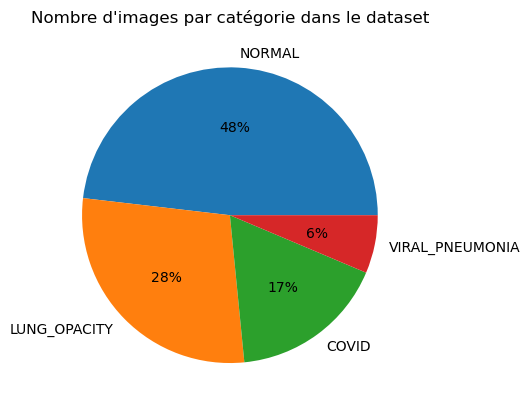

In [106]:
#Compter les fichiers dans chaque catégorie
plt.pie(df_global["SET"].value_counts(), labels = df_global["SET"].value_counts().index, autopct="%.0f%%")
plt.title("Nombre d'images par catégorie dans le dataset")
plt.show();

### Répartition des sources

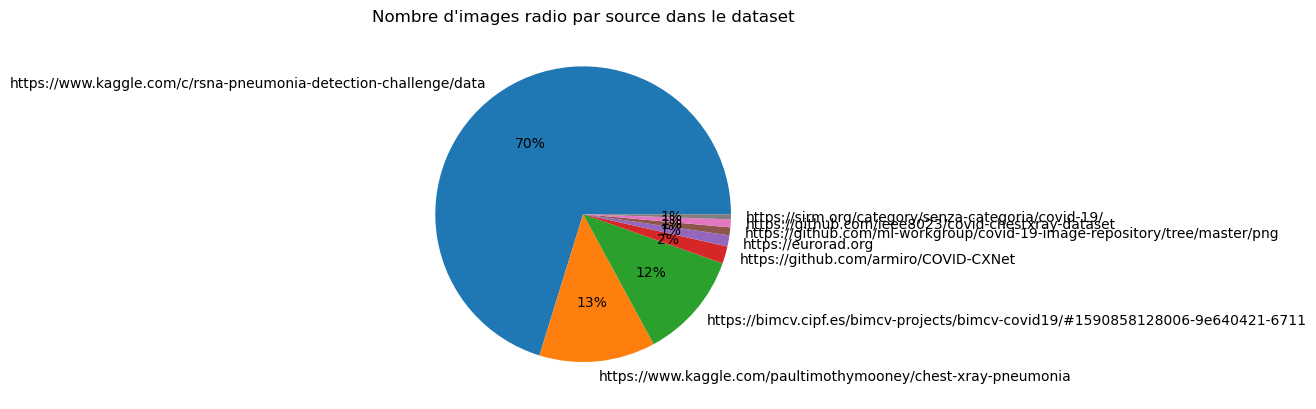

In [107]:
#Compter les fichiers dans chaque catégorie
plt.pie(df_global["URL"].value_counts(), labels = df_global["URL"].value_counts().index, autopct="%.0f%%")
plt.title("Nombre d'images radio par source dans le dataset")
plt.show();

In [23]:
print(np.random.randint(1, len(dims_df.index)))

dims_df.loc[1024, "filepath"]

133


WindowsPath('../data/Viral Pneumonia/images/Viral Pneumonia-71.png')

### Affichage de quelques images au hasard


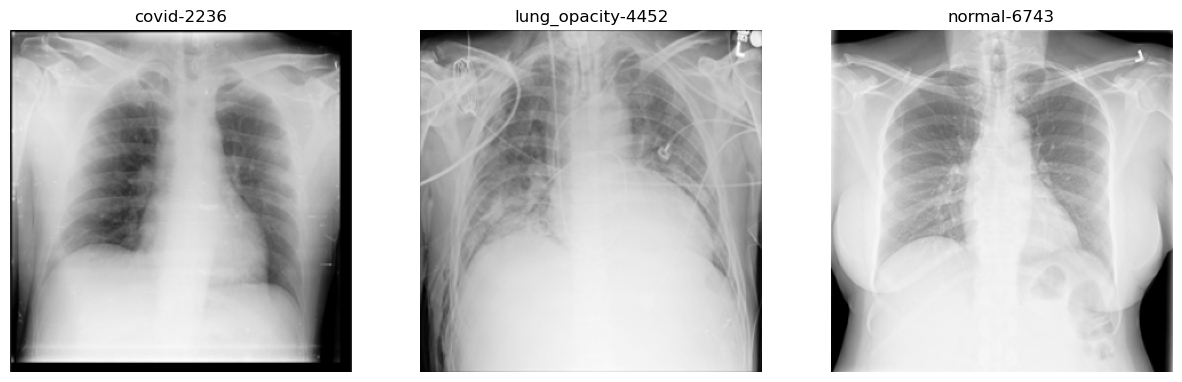

In [151]:
#Affichage de quelques images au hasard
#Création subplots
fig = plt.figure(figsize = (15, 10))
for i in range(3):
    img_index = np.random.randint(1, len(df_global.index))
    #ouvrir l'image
    img = Image.open(df_global.loc[img_index, "filepath"])
    label = df_global.loc[img_index, "FILE NAME"]
    ax = fig.add_subplot(1, 3, i+1)
    plt.imshow(img, cmap = "Greys_r")
    plt.axis("off")
    plt.title(label)
plt.show();




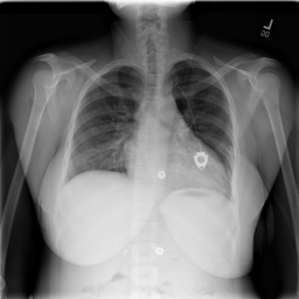

[[214 209 202 ... 172 178 174]
 [175 161 149 ...  86 101 111]
 [105  84  65 ...  25  37  48]
 ...
 [161 126  96 ...  85  94 103]
 [168 125  97 ...  94  98 102]
 [161 120  98 ... 103 106 109]]


(299, 299)

In [130]:
#Test sur une image sélectionnée au hasard
img_index = np.random.randint(1, len(df_global.index))
#ouvrir l'image
img = Image.open(dims_df.loc[img_index, "filepath"])
display(img)
img.size
img.mode
img.getbands()
img_array = np.array(img)
print(img_array)
img_array.shape

In [146]:
df_global["SET"].value_counts().index

Index(['NORMAL', 'LUNG_OPACITY', 'COVID', 'VIRAL_PNEUMONIA'], dtype='object')

### Image moyenne par classe

In [39]:
#Nouvelle fonction de calcul de l'image moyenne à partir d'un array

def find_mean_img(matrice, titre):
    #calculer la moyenne
    mean_img = np.mean(matrice[:,3:].astype("float"), axis = 0)
    #reshaper en format 299x299
    mean_img = mean_img.reshape((299,299))
    plt.imshow(mean_img, cmap = "Greys_r")
    plt.axis("off")
    plt.title(f"Img moyenne {titre}")
    return mean_img

array([[85. , 70.5, 57. , ..., 45.5, 46. , 46.5],
       [84. , 69.5, 56. , ..., 30. , 30.5, 31.5],
       [83. , 68.5, 55.5, ..., 19.5, 20. , 20.5],
       ...,
       [20.5, 14. ,  9.5, ...,  1.5,  3. ,  6.5],
       [21.5, 15. , 10.5, ...,  1.5,  3. ,  6.5],
       [22. , 16.5, 12. , ...,  1.5,  3. ,  6.5]])

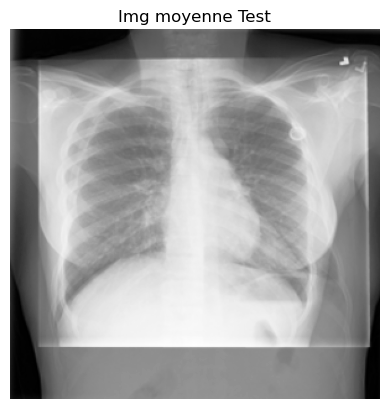

In [40]:
#print(img_database)
#np.mean(img_database[:,3:].astype("float"), axis = 0)
find_mean_img(img_database, "Test")


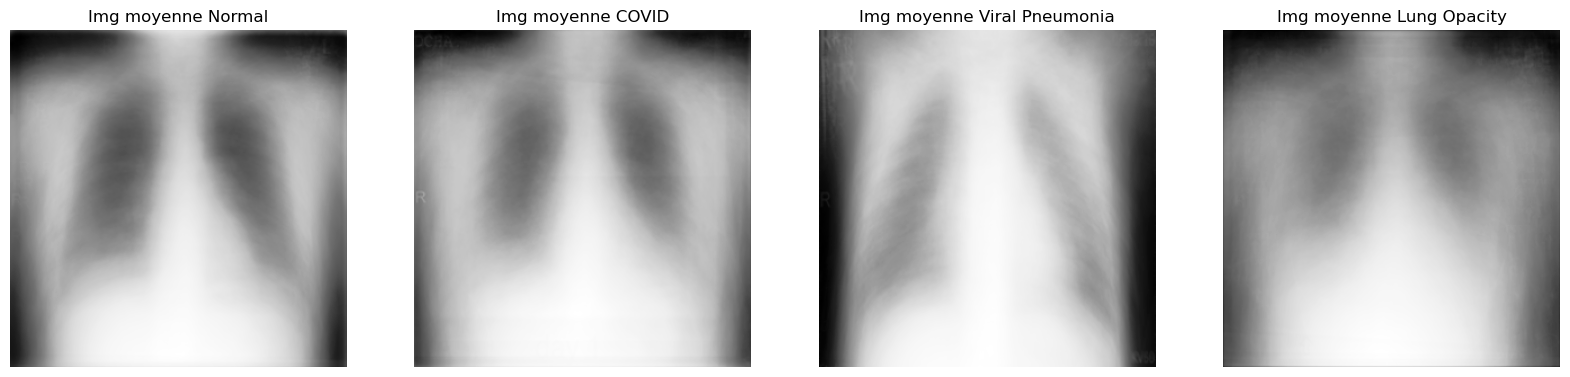

In [44]:
#Calcul et affichage des 4 images moyennes, par classe
fig = plt.figure(figsize = (20, 10))
plt.subplot(141)
norm_mean = find_mean_img(img_db_NORMAL, "Normal")

plt.subplot(142)
covid_mean = find_mean_img(img_db_COVID, "COVID")

plt.subplot(143)
vpneu_mean = find_mean_img(img_db_VPNEUM, "Viral Pneumonia")

plt.subplot(144)
lungo_mean =find_mean_img(img_db_LUNGOP, "Lung Opacity")
plt.show()

100%|██████████| 4/4 [14:11<00:00, 212.84s/it]


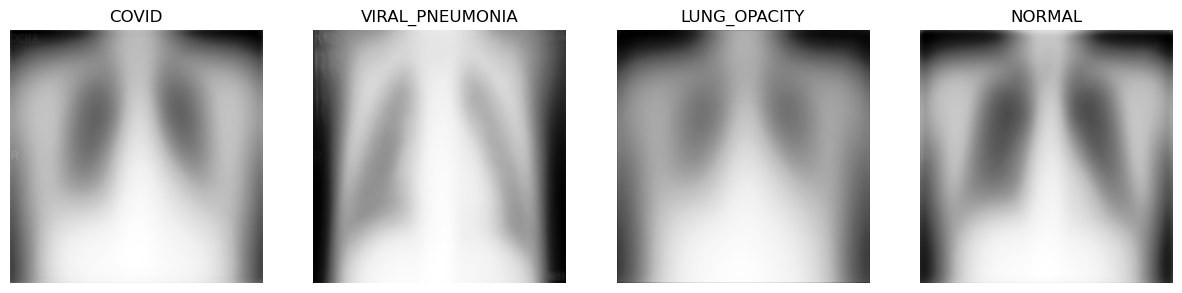

In [158]:
#OBSOLETE Calcul de l'image moyenne 

fig = plt.figure(figsize = (15, 10))

sets = ["COVID", "VIRAL_PNEUMONIA", "LUNG_OPACITY", "NORMAL"]

for set in tqdm(sets):

    df_reduit = df_global[df_global["SET"] == set]

    img_arrays_list = []

    for i in tqdm(df_reduit.index) :
        #ouvrir l'image
        img = Image.open(df_global.loc[i, "filepath"]).convert('L')
        img_array = np.array(img)
        img_arrays_list.append(img_array)

    mean_img = np.mean(img_arrays_list, axis = 0)

    ax = fig.add_subplot(1, 4, sets.index(set) + 1)
    plt.imshow(mean_img, cmap = "Greys_r")
    plt.axis("off")
    plt.title(set)
plt.show();

### Contraste entre normal et chaque maladie

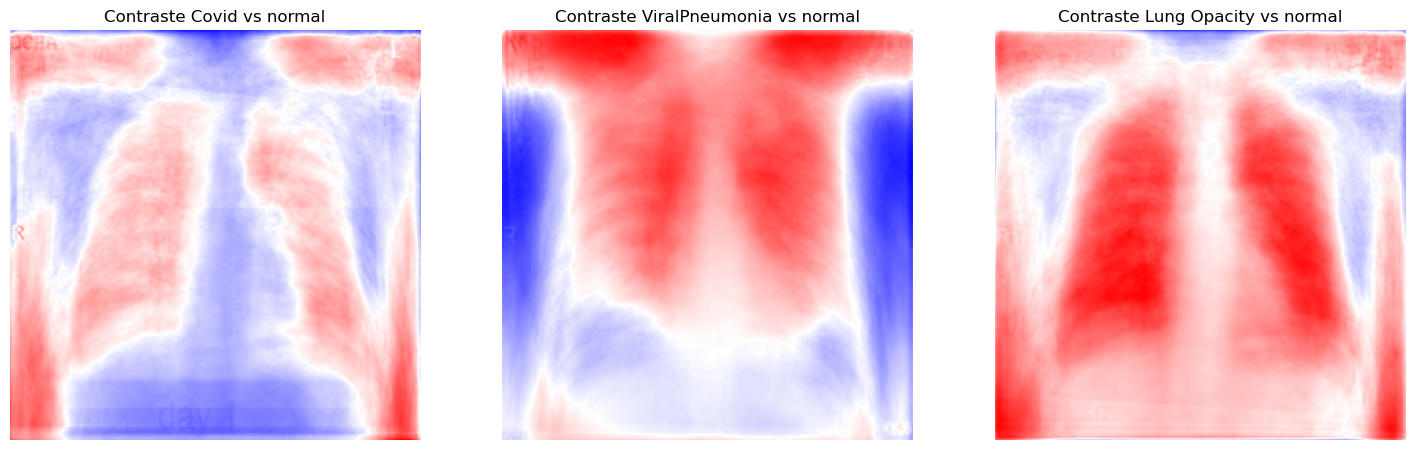

In [52]:
fig = plt.figure(figsize = (18, 8))

contraste_covid = covid_mean - norm_mean
plt.subplot(131)
plt.imshow(contraste_covid, cmap = "bwr")
plt.title("Contraste Covid vs normal")
plt.axis("off")

contraste_ViralPneu = vpneu_mean - norm_mean
plt.subplot(132)
plt.imshow(contraste_ViralPneu, cmap = "bwr")
plt.title("Contraste ViralPneumonia vs normal")
plt.axis("off")

contraste_Lungo = lungo_mean - norm_mean
plt.subplot(133)
plt.imshow(contraste_Lungo, cmap = "bwr")
plt.title("Contraste Lung Opacity vs normal")
plt.axis("off")
plt.show()


### Contraste entre Covid et autres maladies

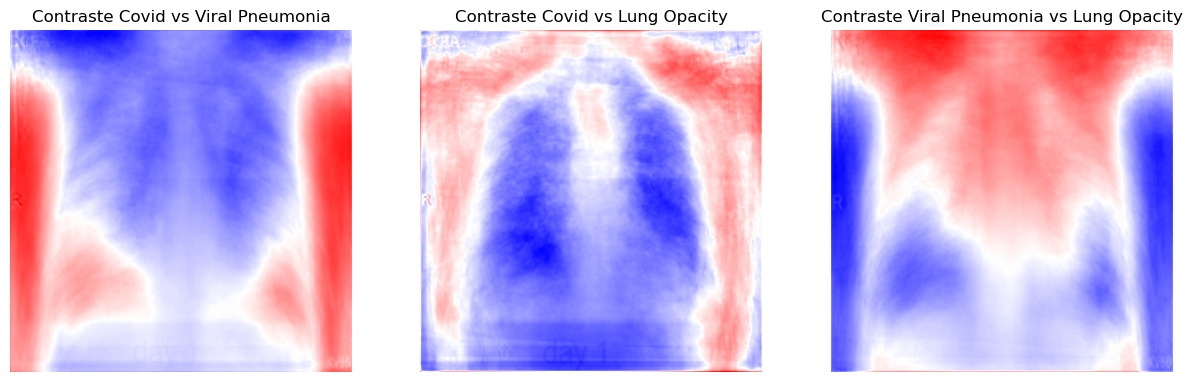

In [77]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize = (15, 5), sharey= True)

contraste_COV_vs_VP = covid_mean - vpneu_mean
ax1.imshow(contraste_COV_vs_VP, cmap = "bwr")
ax1.set_title("Contraste Covid vs Viral Pneumonia")
ax1.axis("off")

contraste_COV_vs_Lungo = covid_mean - lungo_mean
ax2.imshow(contraste_COV_vs_Lungo, cmap = "bwr")
ax2.set_title("Contraste Covid vs Lung Opacity")
ax2.axis("off")

contraste_VP_vs_Lungo = vpneu_mean - lungo_mean
ax3.imshow(contraste_VP_vs_Lungo, cmap = "bwr")
ax3.set_title("Contraste Viral Pneumonia vs Lung Opacity")
ax3.axis("off")

#fig.colorbar(ax2.imshow(contraste_COV_vs_Lungo, cmap = "bwr"))
plt.show()

### Distributions d'intensité par classe

### Luminosité moyenne

Sources :
- https://medium.com/geekculture/eda-for-image-classification-dcada9f2567a